# CS F429 - NLP Project
Project 1: Grammar Check for English Language

## Problem Statement
Part 1: Build a grammar checker using the concepts taught in class, you will be given a corpus with some paragraphs labeled
correct and unknown; correct paragraphs have no grammatical errors, while unknown may/may not have sentences
which have grammatical errors in them. The task is to find all the sentences that have these errors. For example: “In the
country there lived a fox. The quick brown fox jump over the fence. Farmer Shaun was terrified.” In this paragraph, the
sentence “The quick brown fox jump over the fence” is grammatically incorrect.

## Introduction

### Importing libraries

In [1]:
!pip install dill
!pip install -U nltk

In [2]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
import time
import nltk
import random
import spacy
import ssl
from numpy import inf

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
# Downloading required packages
nltk.download('punkt')
nltk.download('brown')
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import brown

# from google.colab import drive
# drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# BASE_DIR = 'gdrive/MyDrive/nlp_project'
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, 'dataset', 'NLP_Q1')
CLEAN_DATASET_PATH = os.path.join(DATASET_PATH, 'clean')
UNKNOWN_DATASET_PATH = os.path.join(DATASET_PATH, 'unknown')

PRINT_LIMIT = 3

### Importing dataset
The dataset consists of 2 directories:
1. Clean - Contains text files containing grammatically correct paragraphs.
2. Unknown - Contains text files containing paragraphs which may or may not be grammatically correct.

In [4]:
# Extracting dataset
from zipfile import ZipFile

if not os.path.isdir(DATASET_PATH):
    dataset_zip_path = os.path.join(BASE_DIR, 'dataset', 'Topic 1.zip')
    dataset_extrat_path = os.path.join(BASE_DIR, 'dataset')
    with ZipFile(dataset_zip_path, 'r') as zip:
        zip.printdir()
        zip.extractall(dataset_extrat_path)
        print('Done!')
else:
    print('Dataset already extracted')

Dataset already extracted


In [5]:
# Reading clean dataset
clean_text_list = []
for file_name in os.listdir(CLEAN_DATASET_PATH):
    text = open(os.path.join(CLEAN_DATASET_PATH, file_name)).read()
    clean_text_list.append(text)

print(f'Size of clean dataset: {len(clean_text_list)}')
print(f'===========================\n')
print('\n\n'.join(random.sample(clean_text_list, PRINT_LIMIT)))

Size of clean dataset: 6969

Soybeans are extensively processed into a remarkable number of food products in the Orient . American chemists , seeking to increase exports of soybeans , have adapted modern techniques and fermentation methods to improve their use in such traditional Japanese foods as tofu and miso and in tempeh of Indonesia . Soybean flour , grits , flakes , `` milk '' , and curd can be bought in the United States .

The lieutenant was not entirely wrong in the belief . There had never been a good reason for Doc Doolittle to grow up . He had come into the Navy too young , with the image of the fun-loving Guns Appleby before him . The war found him much too early , and its perils -- and especially its awful boredom -- were best forgotten in horseplay and elaborate practical jokes , and even now Doc had never found any stabilizing , sobering influence . He remained young at heart , with an overdeveloped sense of humor . He wisecracked about the captain's indoctrination of n

In [6]:
# Reading unknown dataset
unknown_text_list = []
for file_name in os.listdir(UNKNOWN_DATASET_PATH):
    text = open(os.path.join(UNKNOWN_DATASET_PATH, file_name)).read()
    unknown_text_list.append(text)

print(f'Size of unknown dataset: {len(unknown_text_list)}')
print(f'=============================\n')
print('\n\n'.join(random.sample(unknown_text_list, PRINT_LIMIT)))

Size of unknown dataset: 8698

As Hudson resumed his desperate criss - crossing of the little bays , every incident lessened the crew 's respect for him . Once , after the Discovery lay for a week in rough weather , Hudsoning ordered the anchor raised before the sea had calmed . Just as it was being hauled inboard , a plato sea hit the ship . Michael Butt and Adame Moore be thrown off the capstan and badly injured . The anchor cable would have been lost overboard , but Philip Staffe was on hand to saloonkeeper sever it with his axe .

` ` It depends on the widow '' discussed . Lucy had an idea that Myra love it . And for one moment did she believe that Myra had settled down . It seemed to Lucy that all their married life , she and Jim had been doing nothing but rescues his sister from the constant crises that were her way of life . Remembering that succession of disasters , she now considered Cathy , an ominous child - cloud her horizon .

And had n't I rescued him from Warren ? ? She 

#### Preprocessing
Preparing the dataset to draw statistical inferences using language models.

In [7]:
def clean_corpus(corpus):
    for i in range(len(corpus)):
        corpus[i] = corpus[i].lower()
        corpus[i] = corpus[i].replace("` `", '"')
        corpus[i] = corpus[i].replace('``', '"')
        corpus[i] = corpus[i].replace("''", '"')
        corpus[i] = corpus[i].replace("? ?", '?')
        corpus[i] = corpus[i].replace("??", '?')
        corpus[i] = corpus[i].replace("! !", '!')
        corpus[i] = corpus[i].replace("!!", '!')
        corpus[i] = corpus[i].replace("; ;", ';')
        corpus[i] = corpus[i].replace(";;", ';')
        corpus[i] = corpus[i].replace(", ,", ',')
        corpus[i] = corpus[i].replace(",,", ',')

In [8]:
from nltk.tokenize import sent_tokenize
from spacy.lang.en import English

def segmentation(corpus, strategy='nltk'):
    
    clean_corpus(corpus)
    
    segmented_corpus = []
    map_to_corpus_index = []
    
    if strategy == 'nltk':
        # NLTK
        for i, text in enumerate(corpus):
            splits = sent_tokenize(text)
            
            quote_count = 0
            merged_splits = []
            for split in splits:
                if quote_count%2 == 0:
                    merged_splits.append(split)
                else:
                    merged_splits[-1] = merged_splits[-1]+" "+split
                quote_count += split.count('"')
                
            segmented_corpus.extend(merged_splits)
            map_to_corpus_index.extend([i for x in range(len(merged_splits))])
    elif strategy == 'spacy': 
        # Spacy
        nlp = English()
        nlp.add_pipe('sentencizer')
        for i, text in enumerate(corpus):
            my_doc = nlp(text)
            for sent in my_doc.sents:
                segmented_corpus.append(sent.text)
                map_to_corpus_index.append(i)
    elif strategy == None:
        segmented_corpus = corpus
        map_to_corpus_index = [i for i in range(len(corpus))]
    else:
        raise ValueError("Strategy not configured.")
        
    return segmented_corpus, map_to_corpus_index

In [9]:
from nltk.tokenize import word_tokenize

def tokenization(segmented_corpus, strategy='nltk'):
    tokenized_corpus = []
    
    if strategy == 'nltk':
        # NLTK
        for text in segmented_corpus:
            tokenized_corpus.append(word_tokenize(text))
    elif strategy == 'spacy':
        # Spacy
        nlp = English()
        for text in segmented_corpus:
            my_doc = nlp(text)
            token_list = []
            for token in my_doc:
                token_list.append(token.text)
            tokenized_corpus.append(token_list)
    else:
        raise ValueError("Strategy not configured.")
    
    return tokenized_corpus

In [10]:
segmentation_strategy = 'nltk'
tokenization_strategy = 'nltk'

#### Printing examples of segmenting and tokenizing the text in files.

In [11]:
segmented_clean_text_list, map_to_corpus_index = segmentation(clean_text_list, segmentation_strategy)
tokenized_clean_text_list = tokenization(segmented_clean_text_list, tokenization_strategy)

print('Segmentation of clean data')
print('==========================\n')
print('\n\n'.join(segmented_clean_text_list[:PRINT_LIMIT]))
print('\n\nTokenization of clean data')
print('==========================\n')
for i in range(PRINT_LIMIT):
    print(tokenized_clean_text_list[i], end='\n\n')

Segmentation of clean data

the jury further said in term-end presentments that the city executive committee , which had over-all charge of the election , " deserves the praise and thanks of the city of atlanta " for the manner in which the election was conducted .

it urged that the next legislature " provide enabling funds and re-set the effective date so that an orderly implementation of the law may be effected " .

the grand jury took a swipe at the state welfare department's handling of federal funds granted for child welfare services in foster homes .


Tokenization of clean data

['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', '``', 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']

['it', 'urged', 'that', 'the', 'nex

In [12]:
segmented_unknown_text_list, map_to_corpus_index = segmentation(unknown_text_list, segmentation_strategy)
tokenized_unknown_text_list = tokenization(segmented_unknown_text_list, tokenization_strategy)

print('Segmentation of unknown data')
print('============================\n')
print('\n\n'.join(segmented_unknown_text_list[:PRINT_LIMIT]))
print('\n\nTokenization of unknown data')
print('============================\n')
for i in range(PRINT_LIMIT):
    print(tokenized_unknown_text_list[i], end='\n\n')

Segmentation of unknown data

the fulton county grand jury say friday an investigation of atlanta 's recent primary election produced " no evidence " that any irregularities took place .

" this is one of the major items in the fulton county general assistance program " , the jury said , but the state welfare department " has seen fit to distribute these funds through the welfare departments of all the counties in the state with the exception of fulton county , which receives reform none of this money .

the jurors said they realize " a proportionate distribution of these funder might disable this program in our less populous counties " .


Tokenization of unknown data

['the', 'fulton', 'county', 'grand', 'jury', 'say', 'friday', 'an', 'investigation', 'of', 'atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', '``', 'that', 'any', 'irregularities', 'took', 'place', '.']

['``', 'this', 'is', 'one', 'of', 'the', 'major', 'items', 'in', 'the', 'fulton', 

### Dataset Analysis

In [13]:
# Building list of all tokens in clean data
token_list_clean = list()
for i in range(len(tokenized_clean_text_list)):
    token = tokenized_clean_text_list[i]
    for j in range(len(token)):
        token_list_clean.append(token[j])
        
# Building set of all tokens in clean data
token_set_clean = set()
for i in range(len(tokenized_clean_text_list)):
    token = tokenized_clean_text_list[i]
    for j in range(len(token)):
        token_set_clean.add(token[j])

In [14]:
# Building list of all tokens in unknown data
token_list_unknown = list()
for i in range(len(tokenized_unknown_text_list)):
    token = tokenized_unknown_text_list[i]
    for j in range(len(token)):
        token_list_unknown.append(token[j])

# Building set of all tokens in unknown data
token_set_unknown = set()
for i in range(len(tokenized_unknown_text_list)):
    token = tokenized_unknown_text_list[i]
    for j in range(len(token)):
        token_set_unknown.add(token[j])

#### Content and Function Words
Analyzing the clean corpus to count content and function words.

In [15]:
# Calculating function words in clean set
from nltk.corpus import stopwords
from nltk.corpus import words
stop_words = set(stopwords.words('english'))
unclassified_words = set(words.words())
content_words = unclassified_words-stop_words
num_function_words = 0
num_content_words = 0
for i in range(len(token_list_clean)):
    if(token_list_clean[i] in stop_words):
        num_function_words+=1
    elif(token_list_clean[i] in content_words):
        num_content_words+=1
num_total_words = num_function_words+num_content_words

print(f"Number of content words:", num_content_words)
print(f"Number of function words:", num_function_words)

Number of content words: 173222
Number of function words: 211835


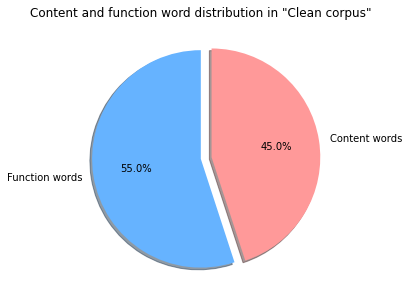

In [16]:
import matplotlib.pyplot as plt
import numpy as np
function_word_percent = round(num_function_words/num_total_words * 100,2)
content_word_percent = round(num_content_words/num_total_words * 100,2)
y = np.array([num_function_words, num_content_words])
# mylabels = ["Function Words "+str(function_word_percent)+"%", "Content words "+str(content_word_percent)+"%"]
mylabels = ["Function words", "Content words"]
explode = (0, 0.1)
colors = ['#66b3ff','#ff9999']
plt.rcParams.update({'figure.figsize':(10, 5)})
plt.pie(y, labels = mylabels, explode=explode, autopct='%1.1f%%',
        colors=colors, shadow=True, startangle=90)
plt.title('Content and function word distribution in "Clean corpus"')
plt.show()

#### Zipf's Law
Verifying Zipf's Law by plotting the frequency distribution using bar graph.

In [17]:
def CountFrequency(my_list):
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

In [18]:
def get_token_freq(token_list):
    mp = CountFrequency(token_list)

    num_list = []
    for key in mp.keys():
        num_list.append(mp[key])

    num_list.sort(reverse = True)
    num_list = num_list[:80]
    return num_list

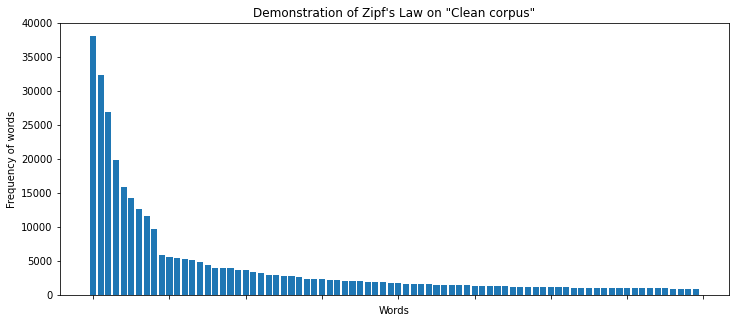

In [19]:
y = get_token_freq(token_list_unknown)
plt.rcParams.update({'figure.figsize':(12, 5)})
plt.bar(list(range(len(y))),y)
frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
plt.xlabel("Words")
plt.ylabel("Frequency of words")
plt.title('Demonstration of Zipf\'s Law on "Clean corpus"')
plt.show()

#### Unknown/Out of vocabulary Words
Checking if there are any unknown/out of vocabulary words in the "Unknown corpus".
If OOV words are present, they must be handled.

In [20]:
# Calculation of unknown words in test set
mp = CountFrequency(token_list_unknown)
num_unknown_words = 0
test_tokens = list(token_set_unknown)
clean_tokens = list(token_set_clean)
for i in range(len(test_tokens)):
    if(test_tokens[i] not in clean_tokens):
        num_unknown_words+= mp[test_tokens[i]]

print(f"Number of unknown words: ", num_unknown_words)
if num_unknown_words > 0:
    print("OOV words detected!")

Number of unknown words:  30788
OOV words detected!


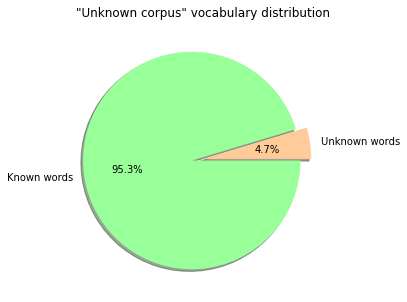

In [21]:
unknown_word_percent = round(num_unknown_words/(len(token_list_unknown)) * 100,2)
known_word_percent = round((len(token_list_unknown)-num_unknown_words)/(len(token_list_unknown)) * 100,2)
y = np.array([num_unknown_words, len(token_list_unknown)-num_unknown_words])
# mylabels = ["Unknown Words "+str(unknown_word_percent)+"%", "Known words "+str(known_word_percent)+"%"]
mylabels = ["Unknown words", "Known words"]
explode = (0, 0.1)
colors = ['#ffcc99', '#99ff99']
plt.rcParams.update({'figure.figsize':(10, 5)})
plt.pie(y, labels = mylabels, explode=explode, autopct='%1.1f%%',
        colors=colors, shadow=True, startangle=0)
plt.title('"Unknown corpus" vocabulary distribution')
plt.show()

## POS Tagging
We have implemented 3 methods to perform POS tagging:
1. Hidden Markov Models
2. Spacy Library
3. NLTK Library

### 1. Hiden Markov Model
We can use hidden markov model to do POS tagging on the token. In the below function, we first find the required probabilities (emission probability, transition probability) using the brown corpus made available by nltk library and use these probabilities to do POS tagging on the given training and testing dataset using Viterbi algorithm.

In [22]:
def training_hmm():
    
    print('Training HMM model ......')
    
    sent_tag = brown.tagged_sents()
    train_data=[]
    for s in sent_tag:
        s.insert(0,('<s>','<s>'))
        s.append(('</s>','</s>'))
        train_data.append(s)
    
    train_word_tag = {}
    for s in train_data:
        for (w,t) in s:
            w=w.lower()
            try:
                try:
                    train_word_tag[t][w]+=1
                except:
                    train_word_tag[t][w]=1
            except:
                train_word_tag[t]={w:1}
        
    train_emission_prob={}
    for k in train_word_tag.keys():
        train_emission_prob[k]={}
        count = sum(train_word_tag[k].values())
        for k2 in train_word_tag[k].keys():
            train_emission_prob[k][k2]=train_word_tag[k][k2]/count
            
    print('Calculated emission probability .........')
            
    bigram_tag_data = {}
    for s in train_data:
        bi=list(nltk.bigrams(s))
        for b1,b2 in bi:
            try:
                try:
                    bigram_tag_data[b1[1]][b2[1]]+=1
                except:
                    bigram_tag_data[b1[1]][b2[1]]=1
            except:
                bigram_tag_data[b1[1]]={b2[1]:1}
                
    bigram_tag_prob={}
    for k in bigram_tag_data.keys():
        bigram_tag_prob[k]={}
        count=sum(bigram_tag_data[k].values())
        for k2 in bigram_tag_data[k].keys():
            bigram_tag_prob[k][k2]=bigram_tag_data[k][k2]/count
            
    print('Calculated bigram transition probability .........')
            
    
    tags_of_tokens = {}
    count=0
    for s in train_data:
        for (w,t) in s:
            w=w.lower()
            try:
                if t not in tags_of_tokens[w]:
                    tags_of_tokens[w].append(t)
            except:
                l = []
                l.append(t)
                tags_of_tokens[w] = l
    
    print('Model training completed .........')
    
    return bigram_tag_prob, train_emission_prob, tags_of_tokens

In [23]:
def find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, string_seq):
    s = string_seq.copy()
    s.append('</s>')
    s.insert(0,'<s>')
    # storing_values is a dictionary which stores the required values          
    storing_values = {}              
    for q in range(len(s)):
        step = s[q]
        # for the starting word of the sentence
        if q == 1:                
            storing_values[q] = {}
            try:
                tags = tags_of_tokens[step]
            except:
                # print(step+'.....')
                tags = ['UNK']
            for t in tags:
                # this is applied since we do not know whether the word in the test data is present in train data or not
                try:
                    storing_values[q][t] = ['<s>',bigram_tag_prob['<s>'][t]*train_emission_prob[t][step]]
                # if word is not present in the train data but present in test data we assign a very low probability of 0.0001
                except:
                    storing_values[q][t] = ['<s>',0.0001]
    
        # if the word is not at the start of the sentence
        if q>1:
            storing_values[q] = {}
            previous_states = list(storing_values[q-1].keys())  
            try:
                current_states  = tags_of_tokens[step]      
            except:
                current_states = ['UNK']
            # calculation of the best previous state for each current state and then storing it in storing_values
            for t in current_states:                             
                temp = []
                for pt in previous_states:                         
                    try:
                        temp.append(storing_values[q-1][pt][1]*bigram_tag_prob[pt][t]*train_emission_prob[t][step])
                    except:
                        temp.append(storing_values[q-1][pt][1]*0.0001)
                max_temp_index = temp.index(max(temp))
                best_pt = previous_states[max_temp_index]
                storing_values[q][t]=[best_pt,max(temp)]

    # Backtracing to extract the best possible tags for the sentence
    pred_tags = []
    total_steps_num = storing_values.keys()
    last_step_num = max(total_steps_num)
    for bs in range(len(total_steps_num)):
        step_num = last_step_num - bs
        if step_num == last_step_num:
            pred_tags.append('</s>')
            pred_tags.append(storing_values[step_num]['</s>'][0])
        if step_num<last_step_num and step_num>0:
            pred_tags.append(storing_values[step_num][pred_tags[len(pred_tags)-1]][0])
    
    return list(reversed(pred_tags[1:-1]))

In [24]:
bigram_tag_prob, train_emission_prob, tags_of_tokens = training_hmm()

Training HMM model ......
Calculated emission probability .........
Calculated bigram transition probability .........
Model training completed .........


In [25]:
find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, ['that','is','a','human'])

['DT', 'BEZ', 'AT', 'JJ']

### Method 2. Spacy Library
We can use spacy `en_core_web_sm` which is a english pipeline trained on various corpora to do POS tagging on the given training and testing dataset.

In [26]:
def train_spacy_pos():
    print('Training spacy model ......')
    nlp_spacy = spacy.load("en_core_web_sm")
    print('Training spacy model completed ......')
    return nlp_spacy

In [27]:
def find_pos_tags_spacy(nlp_spacy , text):
    text = ' '.join(text)
    doc = nlp_spacy(text)
    token = [token.tag_  for token in doc]    
    return token

In [28]:
nlp_spacy = train_spacy_pos()

Training spacy model ......
Training spacy model completed ......


In [29]:
find_pos_tags_spacy(nlp_spacy , ['that','is','a','human'])

['DT', 'VBZ', 'DT', 'JJ']

### Method 3. NLTK Library

In [30]:
from nltk import pos_tag
def find_pos_tags_nltk(text):
    token_pairs = nltk.pos_tag(text)
    tags = []
    for i in token_pairs:
        tags.append(i[1])
    return tags

In [31]:
find_pos_tags_nltk(['that','is','a','human'])

['DT', 'VBZ', 'DT', 'JJ']

##### Function used to do POS tagging of a corpus.

In [32]:
def convert_to_pos_tags(tokenized_corpus, pos_type=None):
    # POS tagging
    pos_tag_corpus = []
    if pos_type == 'hmm':
        print("Replacing tokens with POS tags using HMM")
        for sequence in tokenized_corpus:
            pos_tag_corpus.append(find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, sequence))
        return pos_tag_corpus
    elif pos_type == 'spacy':
        print("Replacing tokens with POS tags using spacy")
        for sequence in tokenized_corpus:
            pos_tag_corpus.append(find_pos_tags_spacy(nlp_spacy, sequence))
        return pos_tag_corpus
    elif pos_type == 'nltk':
        print("Replacing tokens with POS tags using nltk")
        for sequence in tokenized_corpus:
            pos_tag_corpus.append(find_pos_tags_nltk(sequence))
        return pos_tag_corpus
    else:
        print("POS tagging method not selected. No changes made.")
        return tokenized_corpus

## Language Model

### Splitting dataset
Splitting the "Clean corpus" into train set and dev set. The dev set will be used for model evaluation using perplexity calculation.

In [33]:
from sklearn.model_selection import train_test_split
clean_text_list, clean_text_dev_list = train_test_split(clean_text_list, test_size=0.1)

print(f'Size of clean trainset:\t{len(clean_text_list)}')
print(f'Size of clean devset:\t{len(clean_text_dev_list)}')

Size of clean trainset:	6272
Size of clean devset:	697


### N-gram Model
Implementing n-gram model to learn from "Clean corpus". The information extracted will be used for calculating conditional probabilities to get inferences to classify whether the sentece is grammatically correct or not.

In [34]:
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.util import pad_sequence
from nltk.lm import Laplace
from nltk.lm import MLE
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

#### Training n-gram model
The following steps have been taken to train the language model:
1. Segmenting and Tokenizing the text.
2. Padding the tokenized sequence with start symbol `<s>` and end symbol `</s>`. Number of symbols appended will depend on the `n_value` of the n-gram model.
3. Vocabulary- creating vocabulary to handle the Unknown/OOV words in the "Unknown corpus"
    - The words occuring greater than or equals to 2 times will be considered as a part of the vocabulary.
    - The words occuring less than or equal to 1 time are out of the vocabulary and will be considered equivalent to `<UNK>` token for calculations.
4. Add-1 smoothing- Using add-1 smoothing to address scenarios related to determining probability / likelihood estimate of a sequence of words occuring together when one or more words individually (unigram) or N-grams such as bigram(wi/wi−1) or trigram (wi/wi−1wi−2) in the given set have never occured in the past.
5. Saving the scores of the tokens in the sequence for further evaluations.

In [35]:
def train_ngram_model(n_value, tokenized_corpus, verbose=False):
    print(f'{"Sequences in corpus:":50}{len(tokenized_corpus)}')
    total_tokens = 0
    for sequence in tokenized_corpus:
        total_tokens += len(sequence)
    print(f'{"Total tokens in corpus:":50}{total_tokens}')
    
    # padding <s> and </s>
    print("Padding sequences with <s> and </s> tokens")
    padded_sequences = []
    for i in range(len(tokenized_corpus)):
        padded_tokens = list(pad_sequence(tokenized_corpus[i],
                                          pad_left=True, left_pad_symbol="<s>",
                                          pad_right=True, right_pad_symbol="</s>",
                                          n=n_value))
        padded_sequences.append(padded_tokens)
    if verbose:
        print('eg.', padded_sequences[0])
            
    # create vocabulary
    print("Creating vocabulary")
    vocabulary = list(flatten(padded_sequences))
    print(f'{"Flattened sequence size":50}{len(vocabulary)}')
    print(f'{"Flattened sequence set size":50}{len(set(vocabulary))}')
    # replace tokens below cutoff freq with <UNK> token
    vocab = Vocabulary(vocabulary, unk_cutoff=2)
    print(f'{"Vocabulary with <UNK> cutoff size":50}{len(vocab)}')
    
    # grouping into group size of `n_value`
    print("Creating n-grams")
    ngram_sequences = []
    for text in padded_sequences:
        ngram_sequences.append(list(ngrams(text, n=n_value)))
    if verbose:
        print('eg.', ngram_sequences[0][:PRINT_LIMIT])
    
    total_ngrams = 0
    for sequence in ngram_sequences:
        total_ngrams += len(sequence)
    print(f'{"Total ngram sequences:":50}{len(ngram_sequences)}\n{"Total ngrams:":50}{total_ngrams}')
        
    # language model
    print("Creating language model")
    model = Laplace(n_value)
    model.fit(ngram_sequences, vocab)
    print(f'{"Model vocab size:":50}{len(model.vocab)}')
    # print(f"Grand total number of ngrams stored:\t{model.N()}")
    # print(f'{"Total n-grams of size "+str(n_value)+" in model:":50}{len(model.counts[n_value].items())}')
    
    sequence_scores = []
    sequence_token_scores = []
    for ngram_sequence in ngram_sequences:
        sequence_score = 0
        sequence_token_score = []
        for group in ngram_sequence:
            score = model.logscore(group[-1], group[:-1])
            sequence_score += score
            sequence_token_score.append(score)
        sequence_scores.append(sequence_score/len(ngram_sequence))
        sequence_token_scores.append(sequence_token_score)
        
    return {
        'padded_sequences': padded_sequences,
        'vocabulary': vocab,
        'ngram_sequences': ngram_sequences,
        'model': model,
        'sequence_scores': sequence_scores,
        'sequence_token_scores': sequence_token_scores
    }    

In [36]:
def filter_using_sequence_score(n_value, ngram_sequences, sequence_scores, log_cutoff, verbose=False):
    # finding suspect sequences using sequence cutoffs
    
    print('Filtering sequences based on sequence scores')
    suspect_indexes = []
    for i in range(len(ngram_sequences)):
        if sequence_scores[i] < log_cutoff:
            suspect_indexes.append(i)
    if verbose:
        print(f'{"Suspect sequences based on sequence scores:":50}{len(suspect_indexes)}/{len(ngram_sequences)}')
    return suspect_indexes

In [37]:
def plot_continuous_freq_dist(values, xlabel, ylabel, title, bins=50, cutoff=None):
    # plot freq distribution for cutoff visualization
    plt.rcParams.update({'figure.figsize':(10, 3)})
    plt.hist(values, bins=bins)
    if cutoff:
        plt.axvline(x=cutoff, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel);
    plt.show()

In [38]:
def get_sequence_score_cutoff(sequence_scores, alpha=0.05):
    scores = sequence_scores.copy()
    n = len(scores)
    scores.sort()
    index = max(0, min(n-1, int(n*alpha)))
    return scores[index]

Using `alpha` value to dynamically set a cutoff value which will be used as a threshold to detect suspected sequences.

In [39]:
n_values = [i+1 for i in range(10)]
# alpha: used to calculate score cutoff value
alpha = 0.02
pos_type = 'nltk'

In [40]:
def train_lm(n_values, train_corpus, alpha):
    ngram_data = dict()
    for n_value in n_values:
        print(f"Training {n_value}-gram model")
        ngram_model_info = train_ngram_model(n_value, train_corpus, verbose=False)
        ngram_data[n_value] = ngram_model_info

        # filter_using_token_score(n_value, ngram_model_info['model'], ngram_model_info['ngram_sequences'], token_log_cutoffs[n_value], verbose=True)

        sequence_score_log_cutoff = get_sequence_score_cutoff(ngram_model_info['sequence_scores'], alpha=alpha)
        filter_using_sequence_score(n_value, ngram_model_info['ngram_sequences'], ngram_model_info['sequence_scores'], 
                                    sequence_score_log_cutoff, verbose=True)
        print(f'{"Sequence score cutoff:":50}{sequence_score_log_cutoff}\n')
        ngram_data[n_value]['score_cutoff'] = sequence_score_log_cutoff

        plot_continuous_freq_dist(ngram_model_info['sequence_scores'], xlabel='Sequence score', 
                                  ylabel='Frequency', title='Sequence score frequency distribution', bins=200, 
                                  cutoff=sequence_score_log_cutoff)
    return ngram_data

#### Training N-gram model on clean text corpus

Training 1-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           517179
Flattened sequence set size                       32110
Vocabulary with <UNK> cutoff size                 17294
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     517179
Creating language model
Model vocab size:                                 17295
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -11.410993767761257



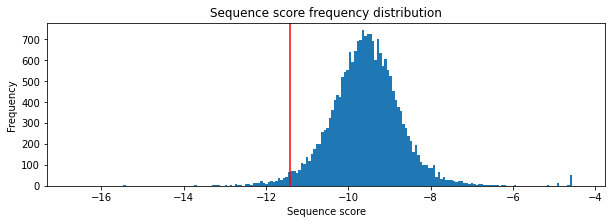

Training 2-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           560391
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     538785
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -11.645983163666871



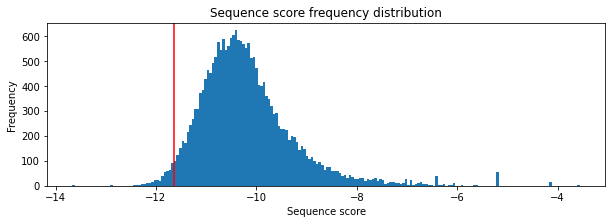

Training 3-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           603603
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     560391
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.551822117860572



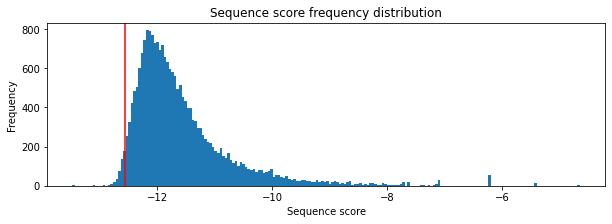

Training 4-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           646815
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     581997
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.76326623044957



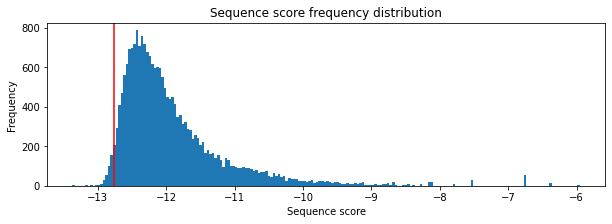

Training 5-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           690027
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     603603
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.806790524541562



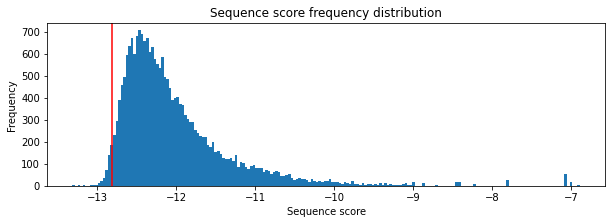

Training 6-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           733239
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     625209
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.817786454072698



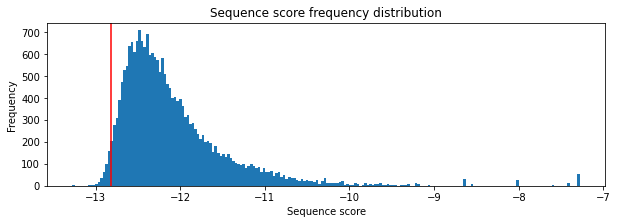

Training 7-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           776451
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     646815
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.823485650611769



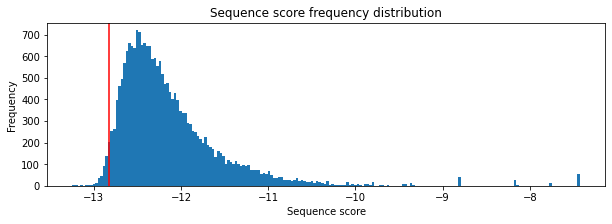

Training 8-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           819663
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     668421
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.829954628297982



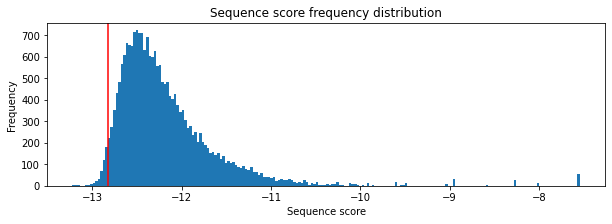

Training 9-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           862875
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     690027
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -12.835128892646436



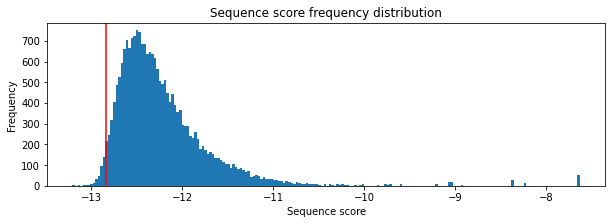

Training 10-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           906087
Flattened sequence set size                       32112
Vocabulary with <UNK> cutoff size                 17296
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     711633
Creating language model
Model vocab size:                                 17297
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       429/21606
Sequence score cutoff:                            -12.838939580109843



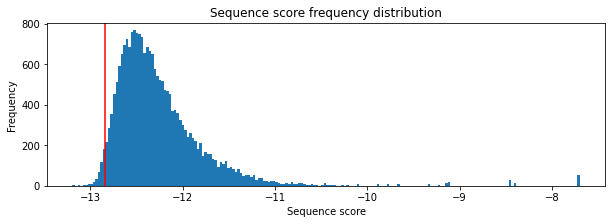

In [41]:
# Text n-gram model
ngram_data_text = train_lm(n_values, tokenized_clean_text_list, alpha=alpha)

#### Training N-gram model on clean POS corpus
The text corpus is first converted into the corresponding POS corpus on which the n-gram models are trained.

Replacing tokens with POS tags using nltk
Training 1-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           517179
Flattened sequence set size                       44
Vocabulary with <UNK> cutoff size                 44
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     517179
Creating language model
Model vocab size:                                 45
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -5.312359125303242



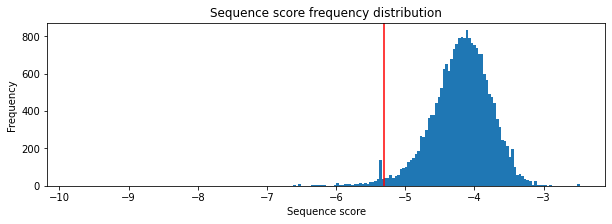

Training 2-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           560391
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     538785
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.363034134281248



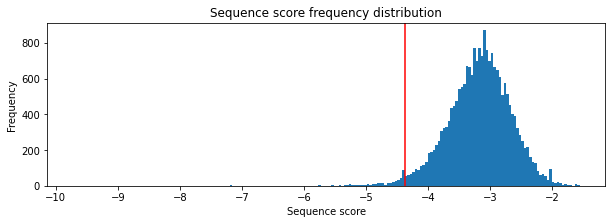

Training 3-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           603603
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     560391
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -3.8267202862412217



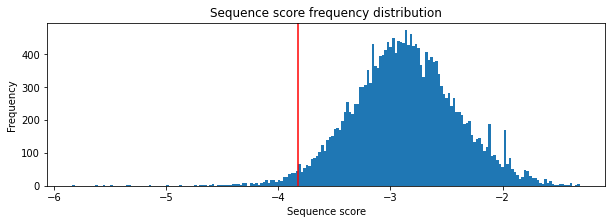

Training 4-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           646815
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     581997
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -3.754995979501993



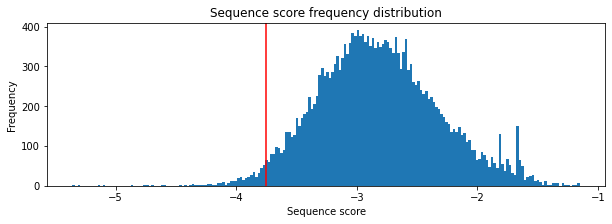

Training 5-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           690027
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     603603
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -3.92881391771522



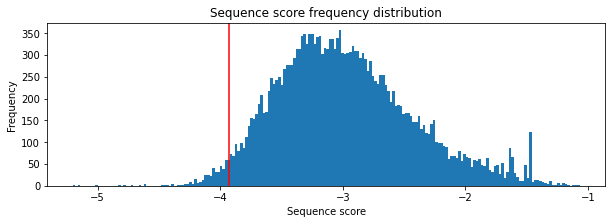

Training 6-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           733239
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     625209
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.109918759175343



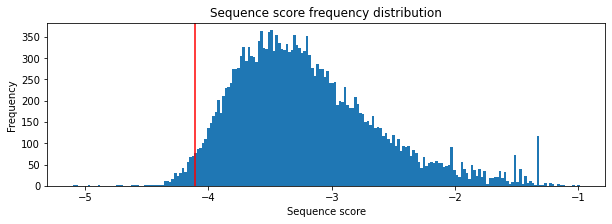

Training 7-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           776451
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     646815
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.217176418295848



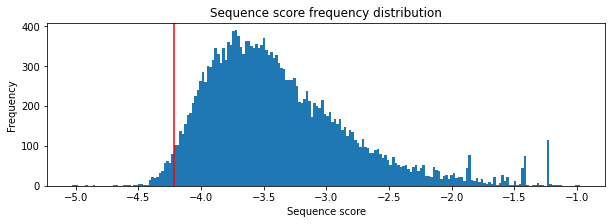

Training 8-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           819663
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     668421
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.277729289039404



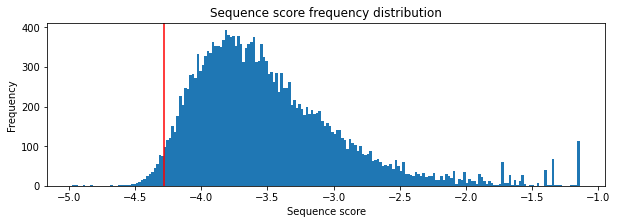

Training 9-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           862875
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     690027
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.31015711688999



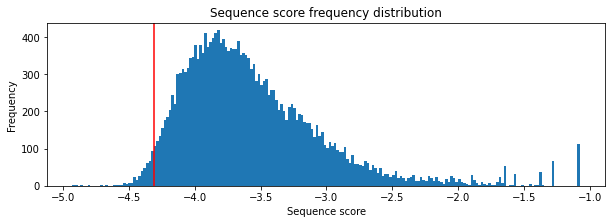

Training 10-gram model
Sequences in corpus:                              21606
Total tokens in corpus:                           517179
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           906087
Flattened sequence set size                       46
Vocabulary with <UNK> cutoff size                 46
Creating n-grams
Total ngram sequences:                            21606
Total ngrams:                                     711633
Creating language model
Model vocab size:                                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       432/21606
Sequence score cutoff:                            -4.322589158101946



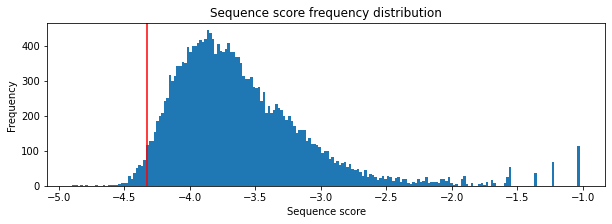

In [42]:
# POS tag n-gram model
clean_pos_tag_list = convert_to_pos_tags(tokenized_clean_text_list, pos_type=pos_type)
ngram_data_pos = train_lm(n_values, clean_pos_tag_list, alpha=alpha)

In [43]:
# Print sample information learned from model

unigram_list = ['<s>', 'of', 'the', '<UNK>']
# [token, context]
ngram_list = [
    ['the', '<s>'], 
    ['the', 'of'], 
    ['a', 'is'],
    ['a', 'this is'],
    ['the', '<s> <s>'], 
    ['<UNK>', 'what is']
]

heading_df = ['N-gram', 'Context', 'Token', 'Count', 'Score', 'Log Score']
list_to_df = []
for token in unigram_list:
    list_to_df.append([
        '1', '', token, 
        ngram_data_text[1]['model'].counts[token], 
        ngram_data_text[1]['model'].score(token), 
        ngram_data_text[1]['model'].logscore(token)
    ])
for token in ngram_list:
    n_value = len(token[1].split())+1
    if n_value not in n_values:
        raise ValueError(f'{n_value}-gram model not available for the given context size {n_value-1} of "{token[1]}".')
    list_to_df.append([
        n_value, token[1], token[0], 
        ngram_data_text[n_value]['model'].counts[token[1].split()][token[0]], 
        ngram_data_text[n_value]['model'].score(token[0], token[1].split()), 
        ngram_data_text[n_value]['model'].logscore(token[0], token[1].split())
    ])

display(pd.DataFrame(list_to_df, columns = heading_df))

,N-gram,Context,Token,Count,Score,Log Score
0,1,,<s>,0,0.027724,-5.172697
1,1,,of,16112,0.030147,-5.051823
2,1,,the,30977,0.057960,-4.108804
3,1,,<UNK>,14817,0.027724,-5.172697
4,2,<s>,the,2716,0.069840,-3.839795
5,2,of,the,4244,0.127062,-2.976400
6,2,is,a,384,0.017624,-5.826301
7,3,this is,a,31,0.001829,-9.094573
8,3,<s> <s>,the,2716,0.069840,-3.839795
9,3,what is,<UNK>,1,0.000115,-13.083895


## Model Evaluation

### Shannon Visualization
Generating sentences from the trained language model.

In [44]:
def get_sentence_from_tokens(tokens):
    filtered_tokens = []
    for token in tokens:
        if token in ['<s>', '</s>']:
            continue
        else:
            filtered_tokens.append(token)
    return ' '.join(filtered_tokens)

In [45]:
from nltk.probability import MLEProbDist

def shannon_visualization(n_value, model, max_len=50, verbose=False):
    sentence = ""
    if n_value == 1:
        # Unigram
        tokens = model.generate(max_len, random_seed=None)
        sentence = get_sentence_from_tokens(tokens)
        if verbose:
            print('1-gram:', sentence)
    else:
        if verbose:
            print(f'{n_value}-gram: ', end='')
        cur_tokens = ['<s>']*(n_value-1)
        sequence = []
        for _ in range(max_len):
            freq_dist = model.counts[cur_tokens]
            prob_dist = MLEProbDist(freq_dist)
            next_token = prob_dist.generate()
            if next_token == '</s>':
                break
            sequence.append(next_token)
            if verbose:
                print(next_token, end=' ')
            cur_tokens.pop(0)
            cur_tokens.append(next_token)
        sentence = ' '.join(sequence)
        if verbose:
            print()
    return sentence

In [46]:
for n_value in n_values:
    sent = shannon_visualization(n_value, ngram_data_text[n_value]['model'], 50, verbose=False)
    print(f'{n_value}-gram')
    print(f'======')
    print(sent, end='\n\n')

1-gram
killing ages staff called , it of wasteful aid down heavily trade small imagined in month listened has way the when of , no curzon the discovering they visited because 's we remarks it , money is . <UNK> , sixty ) ludicrous `` marks in of initially weakening responsibilities

2-gram
we as in her house and the best known that aerated lagoon into her and immortal .

3-gram
he left town and the flooring is then screwed in place of subjective control -- a <UNK> object swayed <UNK> in london eighteen weeks , till myra finds a place , as shown by the input axis , since the systems of numerous volumes of 30 to 40 megatons thus

4-gram
but , even if its glass doors had never opened .

5-gram
a sudden thought wiped the <UNK> from his face . `` suppose the murderer should return to the scene of the crime . and if you 're as flat broke as i am , i think we ought to set up an election to pick a bargaining agent .

6-gram
and the surface is driven back , in its very <UNK> , only by this cont

## Utility functions to text classification

In [47]:
def analyse_test_corpus(tokenized_corpus, n_value, model, verbose=False):
    
    if verbose:
        print(f'{"Sequences in corpus:":50}{len(tokenized_corpus)}')
    total_tokens = 0
    for sequence in tokenized_corpus:
        total_tokens += len(sequence)
    if verbose:
        print(f'{"Total tokens in corpus:":50}{total_tokens}')
    
    # padding <s> and </s>
    if verbose:
        print("Padding sequences with <s> and </s> tokens")
    padded_sequences = []
    total_tokens_with_padding = 0
    for i in range(len(tokenized_corpus)):
        padded_tokens = list(pad_sequence(tokenized_corpus[i],
                                          pad_left=True, left_pad_symbol="<s>",
                                          pad_right=True, right_pad_symbol="</s>",
                                          n=n_value))
        padded_sequences.append(padded_tokens)
        total_tokens_with_padding += len(padded_tokens)
    
    # grouping into group size of `n_value`
    if verbose:
        print("Creating n-grams")
    ngram_sequences = []
    for text in padded_sequences:
        ngram_sequences.append(list(ngrams(text, n=n_value)))
    
    total_ngrams = 0
    for sequence in ngram_sequences:
        total_ngrams += len(sequence)
    if verbose:
        print(f'{"Total ngram sequences:":50}{len(ngram_sequences)}\n{"Total ngrams:":50}{total_ngrams}')    
    
    
    sequence_scores = []
    sequence_token_scores = []
    total_score = 0
    for ngram_sequence in ngram_sequences:
        sequence_score = 0
        sequence_token_score = []
        for group in ngram_sequence:
            score = model.logscore(group[-1], group[:-1])
            sequence_score += score
            sequence_token_score.append(score)
        sequence_scores.append(sequence_score/len(ngram_sequence))
        total_score += sequence_score
        sequence_token_scores.append(sequence_token_score)
    log_perplexity = -total_score/total_tokens_with_padding
    
    return {
        'padded_sequences': padded_sequences,
        'ngram_sequences': ngram_sequences,
        'sequence_scores': sequence_scores,
        'map_to_corpus_index': map_to_corpus_index,
        'perplexity': log_perplexity,
        'sequence_token_scores': sequence_token_scores
    }

In [48]:
def test_lm(test_corpus, n_values, ngram_data):
    ngram_results = dict()
    for n_value in n_values:
        print(f"Testing {n_value}-gram model")
        ngram_test_info = analyse_test_corpus(test_corpus, n_value, ngram_data[n_value]['model'], verbose=True)
        plot_continuous_freq_dist(ngram_test_info['sequence_scores'], xlabel='Sequence score', 
                                  ylabel='Frequency', title='Sequence score frequency distribution', bins=200,
                                  cutoff=ngram_data[n_value]['score_cutoff'])
        # filter_using_token_score(n_value, ngram_data[n_value]['model'], ngram_test_info['ngram_sequences'], token_log_cutoffs[n_value], verbose=True)
        suspect_sequences_indexes = filter_using_sequence_score(n_value, 
                                                   ngram_test_info['ngram_sequences'], 
                                                   ngram_test_info['sequence_scores'], 
                                                   ngram_data[n_value]['score_cutoff'], verbose=True)
        suspect_corpus_index = []
        for index in suspect_sequences_indexes:
            suspect_corpus_index.append(ngram_test_info['map_to_corpus_index'][index])
        suspect_corpus_index = set(suspect_corpus_index)

        ngram_results[n_value] = dict()
        ngram_results[n_value] = {
            'suspect_corpus_index': suspect_corpus_index,
            'padded_sequences': ngram_test_info['padded_sequences'],
            'ngram_sequences': ngram_test_info['ngram_sequences'],
            'suspect_sequences_index': suspect_sequences_indexes,
            'map_to_corpus_index': ngram_test_info['map_to_corpus_index'],
            'log_perplexity': ngram_test_info['perplexity'],
            'sequence_scores': ngram_test_info['sequence_scores'],
            'sequence_token_scores': ngram_test_info['sequence_token_scores']
        }
        print()
    return ngram_results

In [49]:
def print_stats(text_list, n_values, ngram_results, indexes=None):
    for n_value in n_values:
        if indexes is None:
            continue
        elif indexes == 'all':
            print(f'{n_value}-gram')
            for index in range(len(text_list)):
                print(f"\t{index}:\t{index in ngram_results[n_value]['suspect_corpus_index']}")
        else:
            print(f'{n_value}-gram')
            for index in indexes:
                print(f"\t{index}:\t{index in ngram_results[n_value]['suspect_corpus_index']}")
    
    print('Total sequence generated from unknown corpus:\t', len(ngram_results[n_values[-1]]['padded_sequences']))
    print('Total text files in unknown corpus:\t\t', len(text_list))
    heading_df = ['N-gram', 'Suspect sequences', 'Suspect files']
    list_to_df = []
    for n_value in n_values:
        list_to_df.append([
            n_value,
            len(ngram_results[n_value]['suspect_sequences_index']), 
            len(ngram_results[n_value]['suspect_corpus_index'])
        ])
    display(pd.DataFrame(list_to_df, columns = heading_df))

## Log Perplexity Calculation

In [50]:
def calculate_log_perplexity(text_dev_list, n_values, ngram_data):   
    perplexity = dict()
    for n_value in n_values:
        ngram_test_info = analyse_test_corpus(tokenized_corpus, n_value, 
                                              ngram_data[n_value]['model'], verbose=False)
        perplexity[n_value] = ngram_test_info['perplexity']
    return perplexity

In [51]:
segmented_corpus, map_to_corpus_index = segmentation(clean_text_dev_list, segmentation_strategy)
tokenized_corpus = tokenization(segmented_corpus, tokenization_strategy)

Text n-gram model log perplexities:
	1-gram perplexity = 9.6014004197193
	2-gram perplexity = 10.009099133434093
	3-gram perplexity = 11.021479884471274
	4-gram perplexity = 10.975382692945512
	5-gram perplexity = 10.733329017767812
	6-gram perplexity = 10.490853011320565
	7-gram perplexity = 10.270982726034278
	8-gram perplexity = 10.07317989588966
	9-gram perplexity = 9.895026842154262
	10-gram perplexity = 9.733805962499838


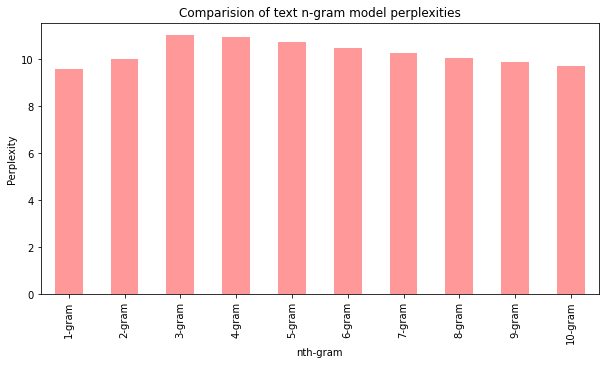

In [52]:
# Perplexity of clean text dev set
print("Text n-gram model log perplexities:")
clean_text_dev_perplexity = calculate_log_perplexity(tokenized_corpus, n_values, ngram_data_text)
for n_value in n_values:
    print(f"\t{n_value}-gram perplexity =", clean_text_dev_perplexity[n_value])
    

text_n_gram_perplexities = []
for n_value in n_values:
    text_n_gram_perplexities.append(clean_text_dev_perplexity[n_value])

freq_series = pd.Series(text_n_gram_perplexities)
x_labels = [f'{n_value}-gram' for n_value in n_values]
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar", color='#ff9999')
ax.set_title("Comparision of text n-gram model perplexities")
ax.set_xlabel("nth-gram")
ax.set_ylabel("Perplexity")
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.show()

Replacing tokens with POS tags using nltk
POS tag n-gram model log perplexities:
	1-gram perplexity = 16.430467140235276
	2-gram perplexity = 6.0038707855087745
	3-gram perplexity = 5.271244609108505
	4-gram perplexity = 5.0859665051566605
	5-gram perplexity = 4.940413171746316
	6-gram perplexity = 4.812065243466473
	7-gram perplexity = 4.698026990974287
	8-gram perplexity = 4.596031032528897
	9-gram perplexity = 4.504265554396926
	10-gram perplexity = 4.421264845306186


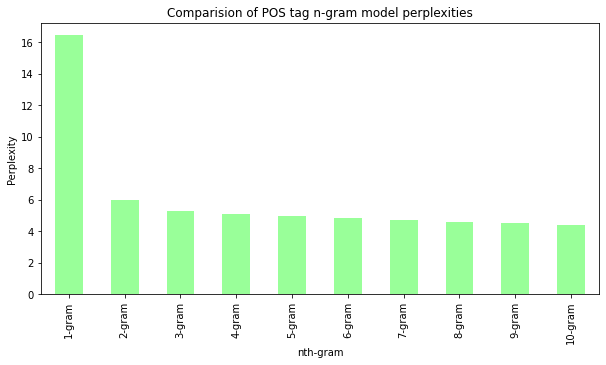

In [53]:
# Perplexity of clean text POS dev set
tokenized_pos_corpus = convert_to_pos_tags(tokenized_corpus, pos_type=pos_type)
print("POS tag n-gram model log perplexities:")
clean_text_dev_pos_perplexity = calculate_log_perplexity(tokenized_pos_corpus, n_values, ngram_data_pos)
for n_value in n_values:
    print(f"\t{n_value}-gram perplexity =", clean_text_dev_pos_perplexity[n_value])


pos_perplexities = []
for n_value in n_values:
    pos_perplexities.append(clean_text_dev_pos_perplexity[n_value])

freq_series = pd.Series(pos_perplexities)
x_labels = [f'{n_value}-gram' for n_value in n_values]
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar", color='#99ff99')
ax.set_title("Comparision of POS tag n-gram model perplexities")
ax.set_xlabel("nth-gram")
ax.set_ylabel("Perplexity")
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.show()

## Analyzing the "Unknown corpus"
1. Segmenting and Tokenizing the text.
2. Padding the tokenized sequence with start symbol `<s>` and end symbol `</s>`. Number of symbols appended will depend on the `n_value` of the n-gram model.
3. Calculating the scores P(w1w2w3) of each sequence in the test set. Normalization is done to ensure fair comparision.
4. Using the cutoff values calculated using the clean train corpus to seperate out the suspected sequences.
5. Saving the scores of the tokens in the sequence for further evaluations.

### Detection strategies explored
1. Use n-gram model trained on text corpus
2. Use n-gram model trained on POS corpus
3. Use a combination of both.

In [54]:
test_text_list = None
# test_text_list = ["In the country there lived a fox. The quick brown fox jump over the fence. " \
#                    "Farmer Shaun was terrified."]

if test_text_list is None:
    test_text_list = unknown_text_list
segmented_corpus, map_to_corpus_index = segmentation(test_text_list, segmentation_strategy)
tokenized_corpus = tokenization(segmented_corpus, tokenization_strategy)

Testing 1-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     661921


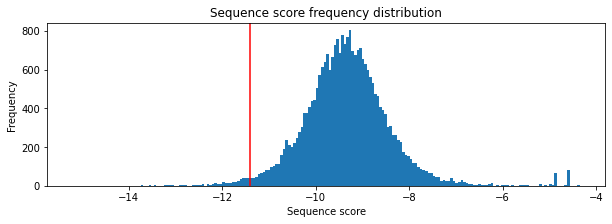

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       398/26430

Testing 2-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     688351


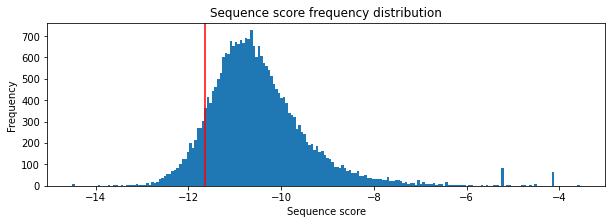

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       2562/26430

Testing 3-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     714781


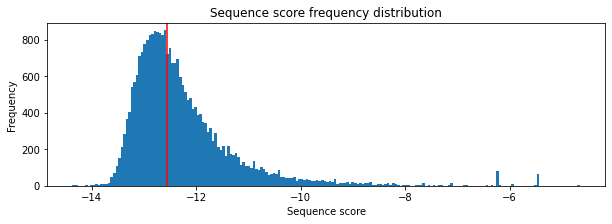

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       12653/26430

Testing 4-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     741211


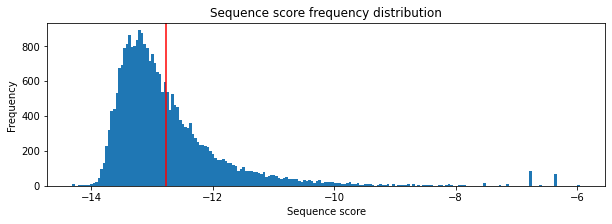

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       16546/26430

Testing 5-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     767641


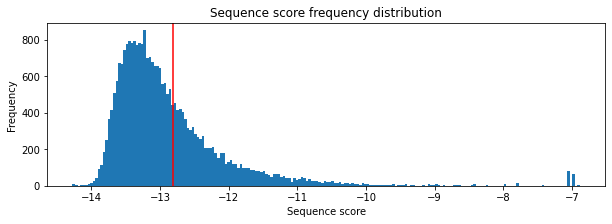

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       17538/26430

Testing 6-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     794071


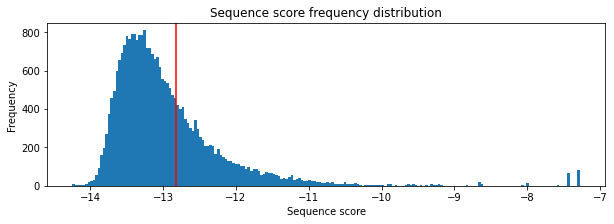

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       18309/26430

Testing 7-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     820501


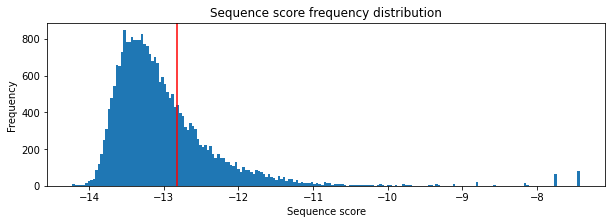

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       18992/26430

Testing 8-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     846931


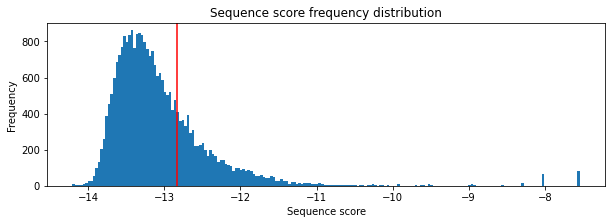

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       19692/26430

Testing 9-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     873361


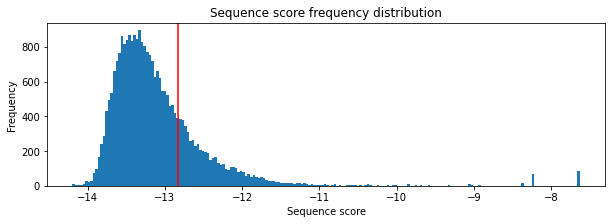

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       20341/26430

Testing 10-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     899791


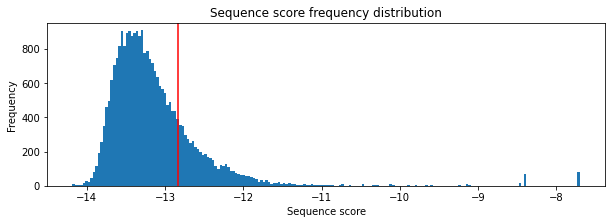

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       21001/26430



In [55]:
# Text n-gram model
ngram_results_text = test_lm(tokenized_corpus, n_values, ngram_data_text)
ngram_results_text['segmented_corpus'] = segmented_corpus

In [56]:
print_stats(test_text_list, n_values, ngram_results_text)
# print_stats(test_text_list, n_values, ngram_results_text, indexes='all')
# print_stats(test_text_list, n_values, ngram_results_text, indexes=[i for i in range(min(3, len(test_text_list)))])

Total sequence generated from unknown corpus:	 26430
Total text files in unknown corpus:		 8698


,N-gram,Suspect sequences,Suspect files
0,1,398,373
1,2,2562,2026
2,3,12653,6433
3,4,16546,7348
4,5,17538,7534
5,6,18309,7673
6,7,18992,7781
7,8,19692,7882
8,9,20341,7964
9,10,21001,8048


Replacing tokens with POS tags using nltk
Testing 1-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     661921


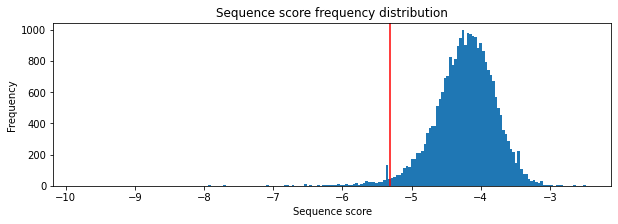

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       547/26430

Testing 2-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     688351


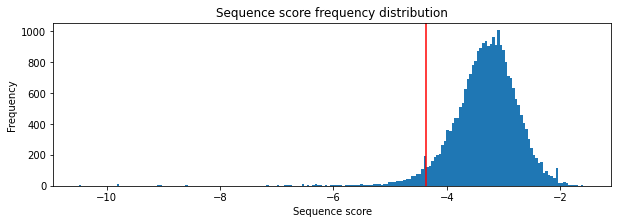

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       1085/26430

Testing 3-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     714781


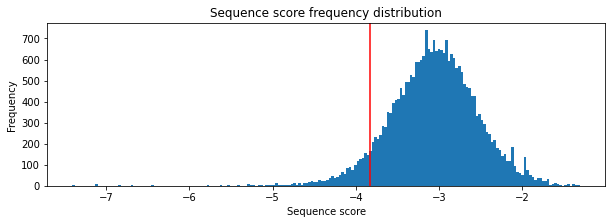

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       1812/26430

Testing 4-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     741211


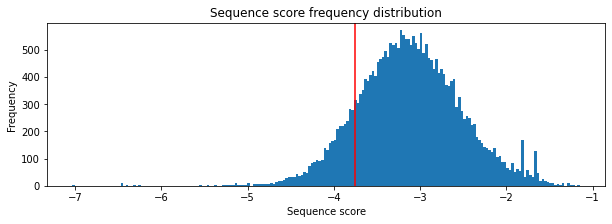

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       3641/26430

Testing 5-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     767641


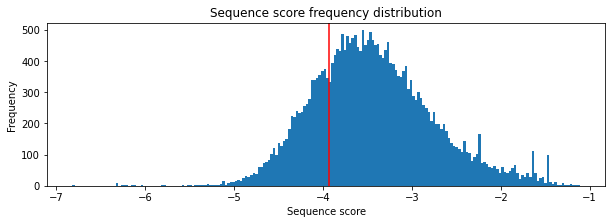

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       6288/26430

Testing 6-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     794071


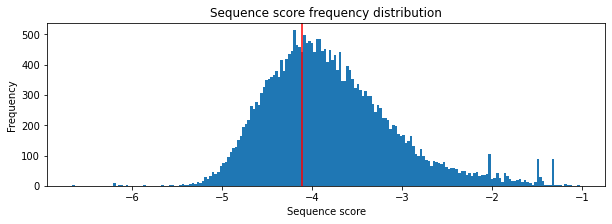

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       9556/26430

Testing 7-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     820501


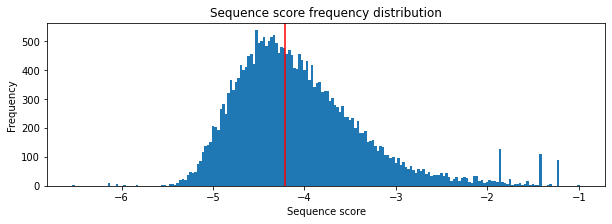

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       12530/26430

Testing 8-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     846931


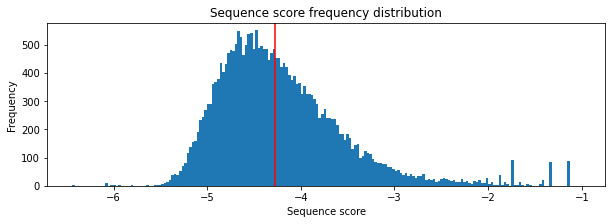

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       14191/26430

Testing 9-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     873361


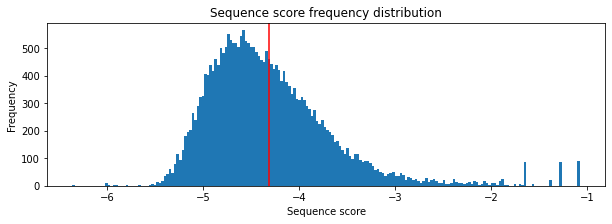

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       15186/26430

Testing 10-gram model
Sequences in corpus:                              26430
Total tokens in corpus:                           661921
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            26430
Total ngrams:                                     899791


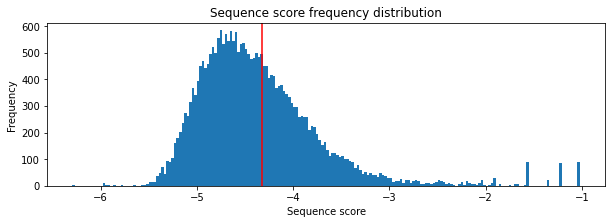

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       16033/26430



In [57]:
# POS tag n-gram model
pos_corpus = convert_to_pos_tags(tokenized_corpus, pos_type=pos_type)
ngram_results_pos = test_lm(pos_corpus, n_values, ngram_data_pos)
ngram_results_pos['segmented_corpus'] = pos_corpus

In [58]:
print_stats(test_text_list, n_values, ngram_results_pos)
# print_stats(test_text_list, n_values, ngram_results_pos, indexes='all')
# print_stats(test_text_list, n_values, ngram_results_pos, indexes=[i for i in range(min(3, len(test_text_list)))])

Total sequence generated from unknown corpus:	 26430
Total text files in unknown corpus:		 8698


,N-gram,Suspect sequences,Suspect files
0,1,547,509
1,2,1085,984
2,3,1812,1591
3,4,3641,2917
4,5,6288,4406
5,6,9556,5870
6,7,12530,6789
7,8,14191,7175
8,9,15186,7399
9,10,16033,7569


In [59]:
common_suspects = dict()
print(f"Size of combined suspect set:")
for n_value in n_values:
    common_suspects[n_value] = list(set(ngram_results_text[n_value]['suspect_corpus_index']) & set(ngram_results_pos[n_value]['suspect_corpus_index']))
    print(f"\t{n_value}-gram: {len(common_suspects[n_value])}/{len(test_text_list)}")

Size of combined suspect set:
	1-gram: 67/8698
	2-gram: 387/8698
	3-gram: 1276/8698
	4-gram: 2622/8698
	5-gram: 4091/8698
	6-gram: 5552/8698
	7-gram: 6488/8698
	8-gram: 6904/8698
	9-gram: 7143/8698
	10-gram: 7330/8698


### Detection strategy used
1. Use the N-gram model trained on the POS tags of the "Clean corpus" to get the suspected sequences.
2. For each suspected sequence, go through the scores of each token and get the token wih the least score.

### Output

#### Displaying random segment classified as suspect by models

In [60]:
def print_corpus_text_from_suspect_sequence_index(index, corpus, n_value, ngram_results):
    n = len(ngram_results[n_value]['suspect_sequences_index'])
    if n == 0:
        return
    index %= n
    sequence_index = ngram_results[n_value]['suspect_sequences_index'][index]
    print('Segment text\n============\n', get_sentence_from_tokens(ngram_results_text[n_value]['padded_sequences'][sequence_index]))
    print('\nSegment POS tags\n================\n', get_sentence_from_tokens(ngram_results_pos[n_value]['padded_sequences'][sequence_index]))
    corpus_index = ngram_results[n_value]['map_to_corpus_index'][sequence_index]
    print('\nCorpus text\n===========\n', corpus[corpus_index])

In [61]:
# Print random suspected sequence
print_corpus_text_from_suspect_sequence_index(
    index=random.randint(0, len(ngram_results_text[n_value]['suspect_sequences_index'])), 
    corpus=test_text_list, n_value=n_values[-1], 
    ngram_results=ngram_results_text
)

Segment text
 butest by 1908 its record of brutality had touched the national conscience .

Segment POS tags
 NN IN CD PRP$ NN IN NN VBD VBN DT JJ NN .

Corpus text
 at first the belgian royal family administered the congo as its own private . butest by 1908 its record of brutality had touched the national conscience . the belgian government itself took over administration , commencing program of paternalism unmatched in the history of colonialism . one definition of paternalism is " the principle or practice , on the part of a government , of managing the affairs of a country waiting in the manner of a father dealing with his children " . the honor of the belgians in this matter is not to be questioned -- only their judgment . ordinarily a father permits his children to grow up in due time -- but when the colony received independence in 1960 the congolese child , if one imagines him to have been born in 1908 , was 52 and had until then been treated as an infant .


#### Testing if a sentence in corpus is classified as suspect by both models (text, POS tag)

In [62]:
# Check if sentence in test corpus is grammatically correct
corpus_index_to_check = 0
print(test_text_list[corpus_index_to_check])
for n_value in n_values:
    print(f'\t{n_value}-gram: \t{corpus_index_to_check not in common_suspects[n_value]}') 

the fulton county grand jury say friday an investigation of atlanta 's recent primary election produced " no evidence " that any irregularities took place .
	1-gram: 	True
	2-gram: 	True
	3-gram: 	True
	4-gram: 	True
	5-gram: 	False
	6-gram: 	False
	7-gram: 	False
	8-gram: 	False
	9-gram: 	False
	10-gram: 	False


## Suggesting correct words

### Calculating the required values
`P(text_token|POS_token)`

In [63]:
def get_word_predict_from_POS(tokenized_clean_text_list, clean_pos_tag_list):
    word_predict_from_POS = {
        '<s>': {'<s>': 1},
        '</s>': {'</s>': 1},
        '<UNK>': {'<UNK>': 1}
    }
    for index in range(len(clean_pos_tag_list)):
        for itr in range(len(clean_pos_tag_list[index])):            
            w=tokenized_clean_text_list[index][itr].lower()
            try:
                try:
                    word_predict_from_POS[clean_pos_tag_list[index][itr]][w]+=1
                except:
                    word_predict_from_POS[clean_pos_tag_list[index][itr]][w]=1
            except:
                word_predict_from_POS[clean_pos_tag_list[index][itr]]={w:1}
    return word_predict_from_POS

word_predict_from_POS = get_word_predict_from_POS(tokenized_clean_text_list, clean_pos_tag_list)

### Strategies explored for suggesting correct words
1. Use text n-gram model: For text token with the least score in each text sequence, replace it with the most probable text token in the current context using the text based n-gram model.
2. Use POS n-gram model:
    1. For POS token with the least score in each POS sequence, replace it with the most probable POS token in the current context using the POS based n-gram model.
    2. Obtain the text token from the POS token using one of the following methods:
        1. 
        ```
        argmax P(text_token|POS_token)
        ```
        2. For all text_token having the predicted POS_token, 
        ```
        argmax P(wi-n+1 .. wi-1|w)P(wi-n+2 .. wi-1 w|wi+1)..P(w wi+1 .. wi+n-2|wi+n-1)
        ```

In [64]:
def suggest_corrections(strategy, n_value, ngram_data_text, ngram_data_pos, 
                        ngram_results_text, ngram_results_pos, word_predict_from_POS, print_limit=100):
    
    # results used for thresholding
    if strategy == 'pos':
        ngram_results = ngram_results_pos
        cutoff = ngram_data_pos[n_value]['score_cutoff']
    elif strategy == 'text':
        ngram_results = ngram_results_text
        cutoff = ngram_data_text[n_value]['score_cutoff']
    elif strategy == 'both':
        raise ValueError('strategy not implemented')
    print(f'Thresholding done using "{strategy}" sequence scores')
    print(f'{n_value}-gram cutoff:\t{cutoff}')
    
    data = {
        'Text': [],
        'Text score': [],
        'POS score': [],
        'Wrong token': [],
        'Wrong token score': [],
        'Wrong token POS': [],
        'Wrong token POS score': [],
        'Suggested POS': [],
        'Suggested token': []
    }    
    for index in ngram_results[n_value]['suspect_sequences_index']:
        
        token_scores = ngram_results[n_value]['sequence_token_scores'][index]
        min_val, min_idx = min((val, idx) for (idx, val) in enumerate(token_scores))
        # text_token_scores = ngram_results_text[n_value]['sequence_token_scores'][index]
        # min_text_token_val, min_text_token_idx = min((val, idx) for (idx, val) in enumerate(text_token_scores))
        
        data['Text'].append(ngram_results_text['segmented_corpus'][index])
        data['Text score'].append(ngram_results_text[n_value]['sequence_scores'][index])
        data['POS score'].append(ngram_results_pos[n_value]['sequence_scores'][index])
        data['Wrong token'].append(ngram_results_text[n_value]['ngram_sequences'][index][min_idx])
        data['Wrong token score'].append(ngram_results_text[n_value]['sequence_token_scores'][index][min_idx])
        data['Wrong token POS'].append(ngram_results_pos[n_value]['ngram_sequences'][index][min_idx])
        data['Wrong token POS score'].append(min_val)
        
        if strategy == 'pos':
            # Get highest P(pos|pos_context)
            pos_gram = ngram_results_pos[n_value]['ngram_sequences'][index][min_idx]
            try:
                suggested_pos_token = ngram_data_pos[n_value]['model'].counts[pos_gram[:-1]].max()
            except:
                suggested_pos_token = None
            # Get highest P(text|pos)
            text_tokens = word_predict_from_POS[suggested_pos_token].keys()
            text_gram = ngram_results_text[n_value]['ngram_sequences'][index][min_idx]
            max_freq = -1
            max_score = -10e6
            suggested_text_token = None
            ngram_sequences = ngram_results_text[n_value]['ngram_sequences'][index]
            for text_token in text_tokens:                    
                skipped = 0
                window_score_sum = 0
                for window_idx in range(n_value):
                    if min_idx+window_idx < len(ngram_sequences):
                        window = list(ngram_sequences[min_idx+window_idx])
                        window[-window_idx-1] = text_token
                        window_score_sum += ngram_data_text[n_value]['model'].logscore(window[-1], window[:-1])
                    else:
                        skipped += 1
                window_score_sum /= (n_value-skipped)
                if max_score < window_score_sum:
                    max_score = window_score_sum
                    suggested_text_token = text_token
            data['Suggested token'].append(suggested_text_token)
            data['Suggested POS'].append(suggested_pos_token)
        elif strategy == 'text':
            # Get highest P(text|text_context)
            text_gram = ngram_results_text[n_value]['ngram_sequences'][index][min_idx]
            try:
                suggested_text_token = ngram_data_text[n_value]['model'].counts[text_gram[:-1]].max()
            except:
                suggested_text_token = None
            data['Suggested token'].append(suggested_text_token)
            data['Suggested POS'].append('')
        elif strategy == 'both':
            raise ValueError('strategy not implemented')
            
        print_limit -= 1
        if print_limit <= 0:
            break
            
    return pd.DataFrame(data)

In [65]:
df = suggest_corrections('pos', 3, ngram_data_text, ngram_data_pos, ngram_results_text, 
                         ngram_results_pos, word_predict_from_POS)

Thresholding done using "pos" sequence scores
3-gram cutoff:	-3.8267202862412217


In [66]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
    display(df)

,Text,Text score,POS score,Wrong token,Wrong token score,Wrong token POS,Wrong token POS score,Suggested POS,Suggested token
0,"regarding atlanta 's new multi - million - dollar airport , the jury recommended "" that when the new sandra management takes charge jan. 1 the airport be operated in a manner that will eliminate political influences "" .",-13.236188,-3.901992,"(the, airport, be)",-14.078484,"(DT, NN, VB)",-9.217642,IN,in
1,his political career goes back to his election to city council in 1923 .est,-12.953957,-4.329064,"(in, 1923, .est)",-10.400223,"(IN, CD, JJS)",-10.759056,NNS,presentments
2,"let her call crosson if she wanted to , let crosson raise the roof or even can him , he did n't care macdonald's .",-12.666810,-4.008406,"(wanted, to, ,)",-14.082565,"(VBD, TO, ,)",-8.280771,VB,be
3,she was married to him for better or for worse .,-11.812748,-3.972383,"(him, for, better)",-14.079235,"(PRP, IN, JJR)",-8.482472,DT,eskimos
4,she would n't 21-2 be wilfully planning his destruction .,-11.604166,-3.909775,"(n't, 21-2, be)",-14.079318,"(RB, JJ, VB)",-9.403545,IN,of
5,"she had caught him offs guard , no preparation , nothing certain but that ahead lay some kind of disaster . "" noing . wait as minute . what do you "" --",-12.897732,-3.862099,"(minute, ., what)",-14.078234,"(NN, ., WP)",-10.399545,</s>,</s>
6,`s ` they were all faded .,-11.684490,-3.838084,"(s, `, they)",-14.078234,"(NNS, ``, PRP)",-8.748193,.,!
7,"worn through at the knees "" . she stood sips and chewing and watching . """,-13.527406,-4.432822,"(``, ., she)",-14.192832,"(``, ., PRP)",-10.995060,</s>,</s>
8,""" now , see here ""er --",-12.173059,-4.625246,"(``, er, --)",-14.099841,"(``, RB, :)",-7.194757,",",","
9,"she smoothed the skirt , sitting down , then stood up and went back to the windows . "" why onning earth did i send him off to work ? there was excuse enough to keep him home that young mr. arthur 'sser still over there "" .",-12.953306,-4.147776,"(young, mr., arthur)",-14.078234,"(JJ, NN, NNP)",-12.260552,IN,prefuh


### Saving model

In [67]:
import dill as pickle 

os.makedirs(os.path.join(BASE_DIR, 'models'), exist_ok=True)

for n_value in n_values:
    with open(os.path.join(BASE_DIR, 'models', f'{n_value}_gram_text.pkl'), 'wb') as fout:
        pickle.dump(ngram_data_text[n_value]['model'], fout)
        
for n_value in n_values:
    with open(os.path.join(BASE_DIR, 'models', f'{n_value}_gram_pos.pkl'), 'wb') as fout:
        pickle.dump(ngram_data_pos[n_value]['model'], fout)

## Contribution
- Adarsh Nandanwar [2018A7PS0396G] - Language Model (n-gram) Train and Test, Language Model Evaluation, Correct Word Suggestion
- Yash Narang [2018A7PS0150G] - POS Tagging: Hidden Markov Model
- Manav Mehta [2018A7PS0164G] - Dataset Analysis
- Aditya Jain [2018A7PS0243G] - POS Tagging: Spacy, Perplexity Calculation
- Pranav Gaur [2018A7PS0099G] - POS Tagging: Spacy, Perplexity Calculation